In [8]:
%load_ext autoreload
%autoreload 2

import cstrees.cstree as ct
import numpy as np
import networkx as nx
import logging, sys
import cstrees.scoring as sc

import matplotlib.pyplot as plt

logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

# CStree from Figure 1 in (Duarte & Solus, 2022)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[1 0 0 0]
 [0 0 1 1]
 [1 0 1 0]
 [0 1 1 0]
 [1 1 0 1]]
level 0
possible context values at row 1: []
[] is in the stage None
possible context values at row 2: []
[] is in the stage None
possible context values at row 3: []
[] is in the stage None
possible context values at row 4: []
[] is in the stage None
[]: {1: 3, 0: 2}
level 1
stages at level 0: []
stages at level 0: []
possible context values at row 1: [0]
[0] is in the stage None
stages at level 0: []
possible context values at row 2: [1]
[1] is in the stage None
stages at level 0: []
possible context values at row 3: [0]
[0] is in the stage None
stages at level 0: []
possible context values at row 4: [1]
[1] is in the stage None
[1]: {0: 2, 1: 1}
[0]: {0: 1, 1: 1}
level 2
stages at level 1: [<cstrees.cstree.Stage object at 0x7fb8c7c0b610>]
stages at level 1: [<cstrees.cstree.Stage object at 0x7fb8c7c0b610>]
possible context values at row 1: [0 0]
[0 0] is in the stage [{0, 1}, 0]
stages at level 1: [<cstrees.cstree.Stage object 

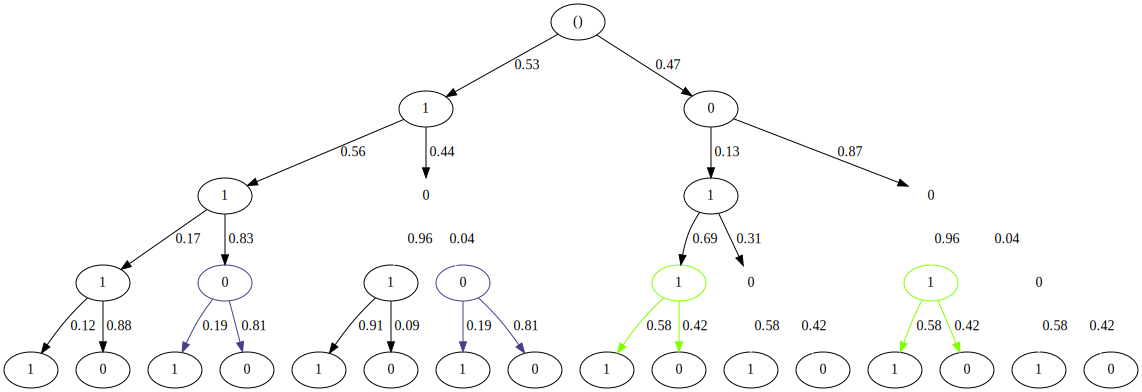

In [9]:
np.random.seed(2)
p=4
cards = [2] * p
co = ct.CausalOrder(range(p))
tree = ct.CStree(co)


#stage = ct.sample_random_stage(cards,2)
#stage.set_random_params(cards)

tree.set_cardinalities(cards)

# These do not have to be in a dict like this as the levels are
# determined from the length of the tuples.

tree.set_stages({
    0: [],
    1: [ct.Stage([{0, 1}, 0])],    # Green
    2: [ct.Stage([0, {0, 1}, 0]),  # Blue
        ct.Stage([0, {0, 1}, 1]),  # Orange
        ct.Stage([1, {0, 1}, 0])]  # Red
})


tree.set_random_stage_parameters()


a = tree.plot()
a.draw("testplot.png")
x = tree.sample(5)

#x = tree.sample(5)
print(x)

s = sc.score(tree, x, alpha_tot=1.0, method="K2")
print(s)
#rels = tree.csi_relations()

#print("Initial rels")
#print(rels)
adjmats = tree.to_minimal_context_graphs()

for key, graph in adjmats.items():
    agraph = nx.nx_agraph.to_agraph(graph)
    agraph.layout("dot")
    agraph.draw(str(key) + "_csi.png", args='-Glabel="'+str(key)+'"   ')
a

In [10]:
tree.to_df()

,0,1,2,3
0,2,2,2,2
0,*,0,-,-
0,0,*,0,-
0,0,*,1,-
0,1,*,0,-


[2, 2, 2, 2]
full_stage_space_size: 2
level: 0, mc: 1, minimal_stage_size: 1
full_stage_space_size: 4
level: 1, mc: 2, minimal_stage_size: 1
full_stage_space_size: 8
level: 2, mc: 2, minimal_stage_size: 2
0 [<cstrees.cstree.Stage object at 0x7fb8b7d756d0>, <cstrees.cstree.Stage object at 0x7fb8b7d75550>]
1 [<cstrees.cstree.Stage object at 0x7fb8b7d758e0>, <cstrees.cstree.Stage object at 0x7fb8b7d758b0>, <cstrees.cstree.Stage object at 0x7fb8b7d75a60>]
2 [<cstrees.cstree.Stage object at 0x7fb8b7d75a90>, <cstrees.cstree.Stage object at 0x7fb8b7d75070>, <cstrees.cstree.Stage object at 0x7fb8b7d75ee0>]
3 []


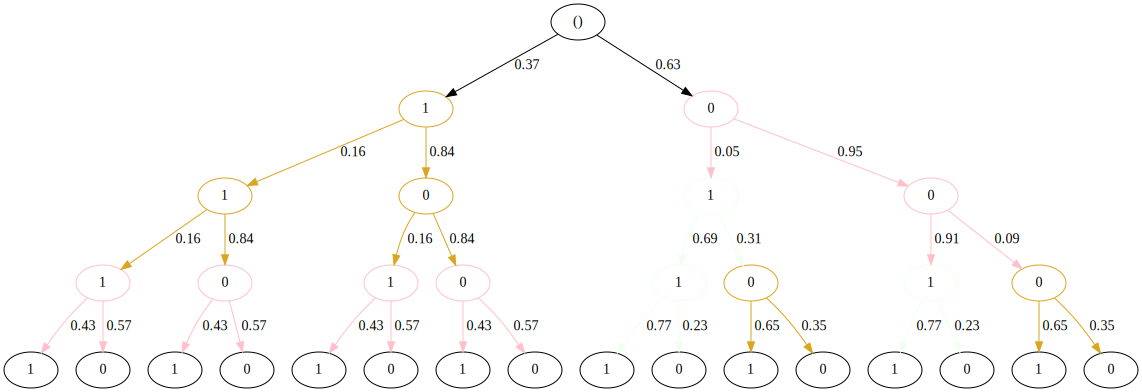

In [127]:

print(cards)
t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=0.5, prop_nonsingleton=1)
t.set_random_stage_parameters()
a = t.plot()
x = t.sample(200)

#plt.savefig("testplot.png")
a



In [128]:

order = [0, 1, 2, 3]
level = 2
score = sc.score_order(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")
print(score)
 

level 0
stagings at level -1:
stages: [<cstrees.cstree.Stage object at 0x7fb8c5732700>]
[]: {1: 74, 0: 126}
staging score: -1591.796577802279
level 0 score: -1591.796577802279
level 1
stagings at level 0:
stages: [<cstrees.cstree.Stage object at 0x7fb8c57324c0>, <cstrees.cstree.Stage object at 0x7fb8c57327f0>]
[1]: {1: 14, 0: 60}
[0]: {0: 123, 1: 3}
staging score: -1401.723828733363
stages: [<cstrees.cstree.Stage object at 0x7fb8bd452fd0>]
[{0, 1}]: {1: 17, 0: 183}
staging score: -1665.4230490193818
level 1 score: -3067.146877752745
level 2
stagings at level 1:
stages: [<cstrees.cstree.Stage object at 0x7fb8c5732850>, <cstrees.cstree.Stage object at 0x7fb8c5732c40>]
[1, {0, 1}]: {1: 19, 0: 55}
[0, {0, 1}]: {1: 115, 0: 11}
staging score: -1371.9544489670172
stages: [<cstrees.cstree.Stage object at 0x7fb8bd452ee0>, <cstrees.cstree.Stage object at 0x7fb8b7d75520>]
[{0, 1}, 1]: {1: 6, 0: 11}
[{0, 1}, 0]: {0: 55, 1: 128}
staging score: -1476.0398384333466
stages: [<cstrees.cstree.Stage obje

In [98]:
from itertools import permutations
a = [0,1,2]
 
# no length entered so default length
# taken as 4(the length of string GeEK)
p = permutations(a)
 
# Print the obtained permutations
for j in list(p):
  print(list(j))

[0, 1, 2]
[0, 2, 1]
[1, 0, 2]
[1, 2, 0]
[2, 0, 1]
[2, 1, 0]


In [101]:
stagings = ct.all_stagings(order, cards, level, max_cvars=1)
print("#Stagings")
nst = ct.n_stagings(order, cards, level, max_cvars=1)
print(nst)
print("Stagings")
for ss in stagings:
    for s in ss:
        print(s)

#Stagings
7
Stagings
[0, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}]
[{0, 1}, 0, {0, 1}]
[{0, 1}, 1, {0, 1}]
[{0, 1}, {0, 1}, 0]
[{0, 1}, {0, 1}, 1]
[{0, 1}, {0, 1}, {0, 1}]


In [129]:
for l in range(len(order)):
    max_staging, max_score = ct.optimal_staging_at_level(order, cards, x, l, max_cvars=1, alpha_tot=1.0, method="BDeu")
    print("best staging at level {}".format(l))
    print(max_score)   
    for st in max_staging:
        print(st)

    

best staging at level 0
-1591.796577802279
[]
best staging at level 1
-1401.723828733363
[0]
[1]
best staging at level 2
-1371.9544489670172
[0, {0, 1}]
[1, {0, 1}]
best staging at level 3
-1338.995569235883
[0, {0, 1}, {0, 1}]
[1, {0, 1}, {0, 1}]


In [126]:
cards

[2, 2, 2, 2]

[]
[0]
[1]
[0, {0, 1}]
[1, {0, 1}]
{0: [<cstrees.cstree.Stage object at 0x7fb8b7cae0d0>], 1: [<cstrees.cstree.Stage object at 0x7fb8b7cf50a0>, <cstrees.cstree.Stage object at 0x7fb8b7cd8940>], 2: [<cstrees.cstree.Stage object at 0x7fb8b7cf5b80>, <cstrees.cstree.Stage object at 0x7fb8b7c210d0>], 3: []}
0 [<cstrees.cstree.Stage object at 0x7fb8b7cae0d0>]
1 [<cstrees.cstree.Stage object at 0x7fb8b7cf50a0>, <cstrees.cstree.Stage object at 0x7fb8b7cd8940>]
2 [<cstrees.cstree.Stage object at 0x7fb8b7cf5b80>, <cstrees.cstree.Stage object at 0x7fb8b7c210d0>]
3 []


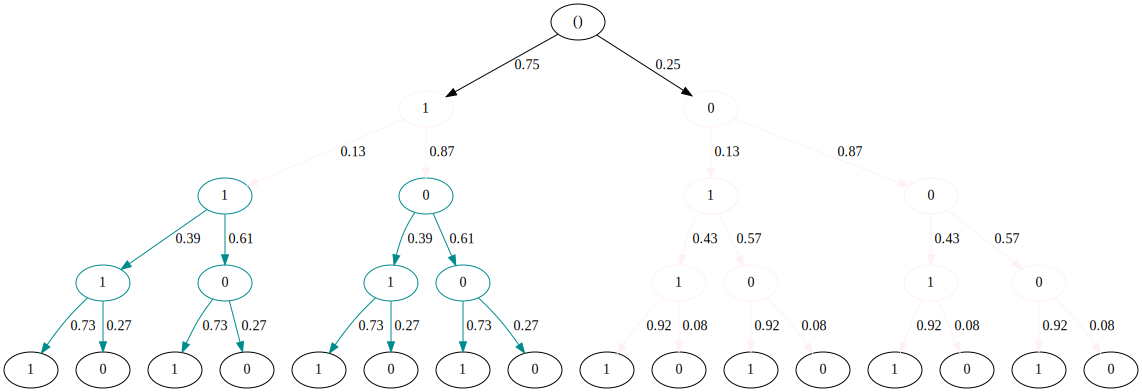

In [132]:
opttree = ct.optimal_cstree(order, cards, x, max_cvars=1, alpha_tot=1.0, method="BDeu")

opttree.set_random_stage_parameters()
opttree.plot()